<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/ML/aula_AM_MLP_para_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

In [0]:
import statsmodels.api as sm

In [0]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] =15, 6

In [0]:
dados = pd.read_csv('sunspot.txt', header=None)

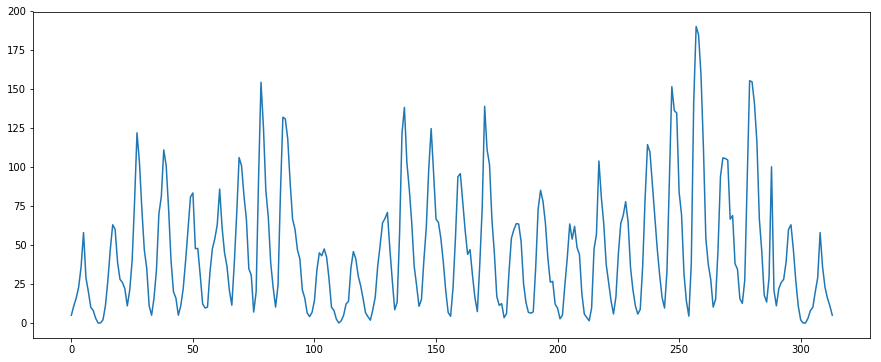

In [6]:
plt.plot(dados)
plt.show()

In [0]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [0]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [0]:
serie = dados.values
serie_normalizada = normalizar_serie(serie)

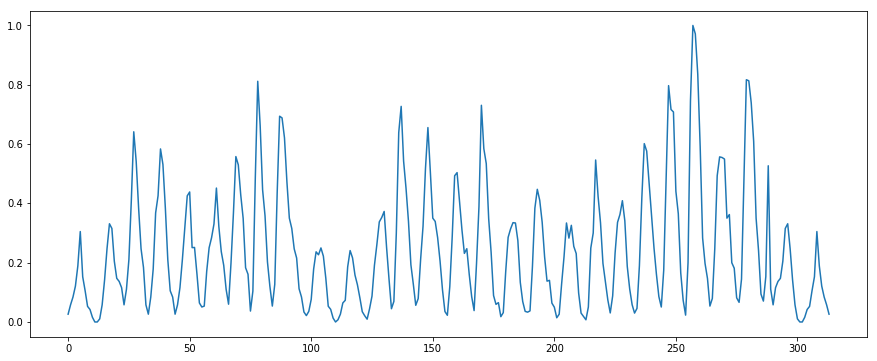

In [10]:
plt.plot(serie_normalizada)
plt.show()

In [0]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [0]:
qtd_lags = 5
janelas = gerar_janelas(5, serie_normalizada)

In [13]:
janelas.shape

(308, 6)

In [0]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()

In [0]:
def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [0]:
serie_diff = diferenciar_serie(dados)

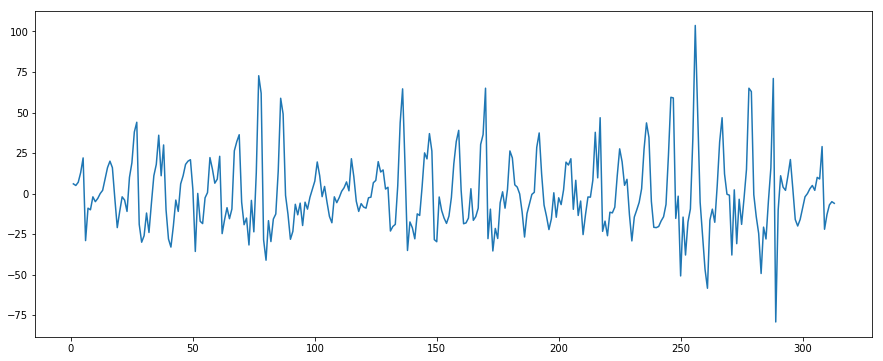

In [17]:
plt.plot(serie_diff)
plt.show()

In [0]:
serie_rt = incrementar_serie(dados.values, serie_diff.values)

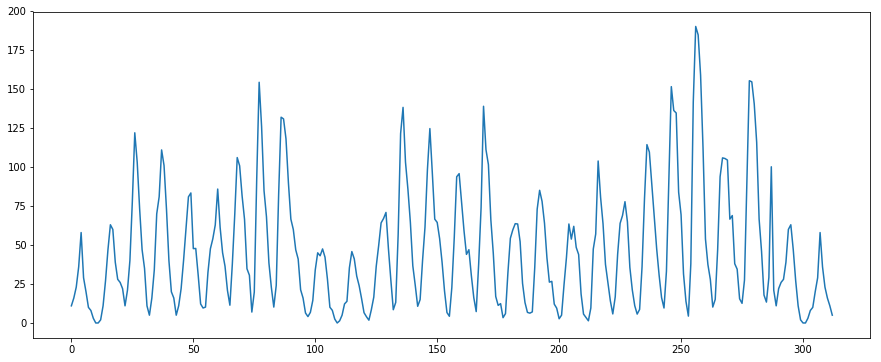

In [21]:
plt.plot(serie_rt)
plt.show()

In [0]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

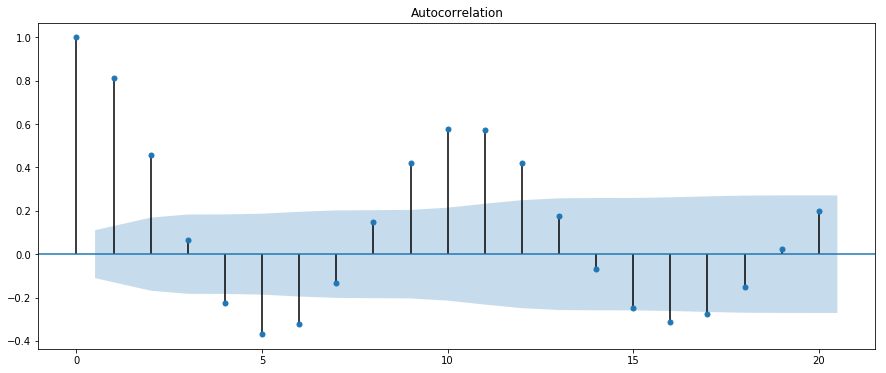

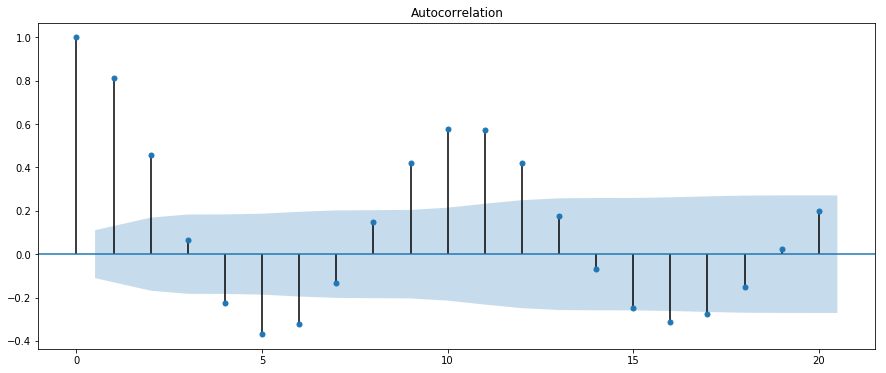

In [23]:
sm.graphics.tsa.plot_acf(serie_normalizada, lags=20)

In [24]:
lag_sel = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 3, 4, 5, 8, 9, 10, 11, 15, 16]


In [25]:
lag_sel

[19, 18, 16, 15, 14, 11, 10, 9, 8, 4, 3]

In [0]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [0]:
tam_janela = 20
serie_janelas = gerar_janelas(tam_janela, serie_normalizada)

In [28]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.70, perc_val = 0.15)

Particao de Treinamento: 0 205
Particao de Validacao: 205 248
Particao de Teste: 248 293


In [0]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
    
    
    neuronios =  [1, 10]    #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['tanh']   #['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs']#, 'sgd', 'adam']
    max_iteracoes = [1000] #[100, 1000, 10000]
    learning_rate = ['constant']  #['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0]+1)): #variar a qtd de pontos utilizados na janela 
                            
                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation[j], solver=alg_treinamento[l], max_iter = max_iteracoes[m], learning_rate= learning_rate[n])
                                
                                
                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag
    
    
    return select_model, qtd_lags_sel

## treinamento

In [30]:
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, 2)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.028295335512947963
Melhor MSE: 0.027553229568355674
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.01382462227218319
QTD de Lags: 3 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.012070862647361097
QTD de Lags: 4 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 5 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 6 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 7 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 8 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.011387581166202856
QTD de Lags: 9 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.011220412723956779
QTD de Lags: 10 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 11 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 12 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 13 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.011043529207917194
QTD de Lags: 14 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 15 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 16 Qtd de Neuron

## teste

In [0]:
predict_train = modelo.predict(x_train[:, -lag_sel:])
predict_val = modelo.predict(x_val[:, -lag_sel:])
predict_test = modelo.predict(x_test[:, -lag_sel:])

In [0]:
previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

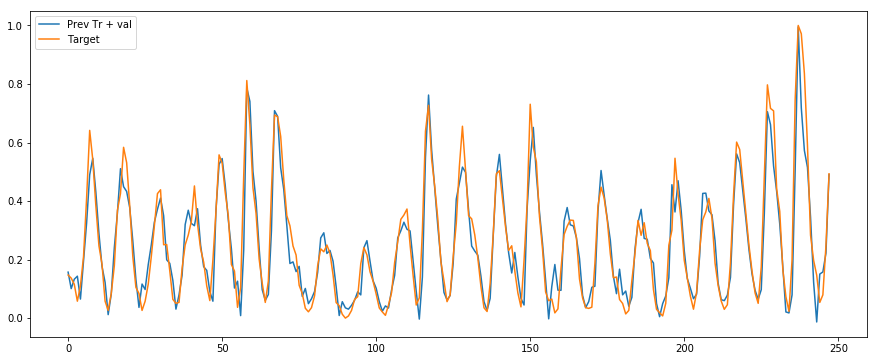

In [33]:
plt.plot(previsoes_train, label = 'Prev Tr + val')
plt.plot(target_train, label='Target')
plt.legend(loc='best')
plt.show()

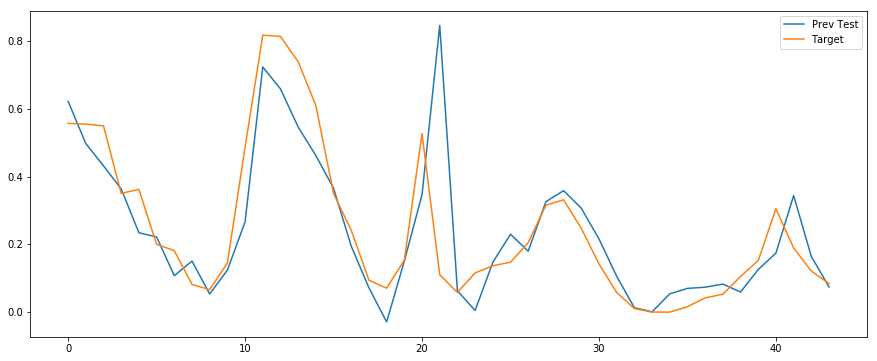

In [34]:
plt.plot(predict_test, label = 'Prev Test')
plt.plot(y_test, label='Target')
plt.legend(loc='best')
plt.show()

In [35]:
MSE(y_test, predict_test)

0.01957402879023299